# Python 3 Specialisation - Final Course Project
## Computer Vision and OCR

### Project Description

Take a ZIP file of newspaper images, stories and advertisements and process them to allow one to search through the images looking for the occurrences of keywords and faces. The end result should be a contact sheet of all the faces in the newspaper page that contain the word that is searched for. For example, if one is to search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza".

Two ZIP files were provided: one large file called images.zip (~200 MB) and one small file called small_img.zip that was used for testing. Each image was saved as a PNG image.

### Results

The project was considered complete and a success if a search for "Christopher" yielded a given contact sheet from the smaller ZIP file (test images), and a given contact sheet was the result from a search for "Mark" from the larger ZIP file. My results were identical to the expected answers and I achieved 100% for this project and course (peer reviewed).

### Import libraries

In [1]:
import cv2 as cv
import numpy as np
import PIL
from PIL import Image, ImageDraw
import pytesseract
import zipfile
from zipfile import ZipFile

In [2]:
# Load the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

In [3]:
# Specify location of zip file and view contents of zip file.
small_file = "readonly/small_img.zip"
with ZipFile(small_file, "r") as zip:
    print(zip.printdir())

File Name                                             Modified             Size
a-0.png                                        2019-02-26 22:30:30     21000053
a-1.png                                        2019-02-26 22:30:28     22598429
a-2.png                                        2019-02-26 22:30:28      3650049
a-3.png                                        2019-02-26 22:30:30     18646538
None


### Functions

In [4]:
# Iterate through zip file, display image and print the image size and mode
def read_files_from_zip(filename, display_image = True):
    """ Function to unzip a zip file of images, opens the image, prints the name of the file,
        display the image and saves the images to the current directory.
        
        :param str filename:
            Location of zipfile.
        :param bool display_image:
            A boolean specifying whether or not to display the images.
            
        :returns:
            The name of the file and displays the image.
    """
    image_files = []
    with ZipFile(filename, "r") as zip_file:
        for entry in zip_file.infolist():
            with zip_file.open(entry) as file:
                img = Image.open(file)
                if display_image:
                    print("The name of the file is: {}".format(file.name))
                    display(img)
                img.save(file.name)
                image_files.append(file.name)
    return image_files

In [5]:
def get_text_from_image(filename):
    """ Function that takes in an image file name and returns a list of words found in the
        text in the image.
        
        :param str filename:
            The name of the file in which to read the text.
            
        :returns list:
            A string of words in the image.   
    """
    image = Image.open(filename)
    image_string = pytesseract.image_to_string(image)
    return image_string

In [6]:
# Function to convert from openCV bounding box to Pillow bounding box
def convert_bounding_box(bb_list):
    """ Converts bounding box of type (x, y, w, h) to type (x1, y1, x2, y2).
        
        :param list bb_list:
            A list of tuples where each tuple is a bounding box of type
            (x, y, w, h).
        
        :returns tuple:
            A tuple containing a bounding box dimensions in the form of
            (x1, y1, x2, y2).
    """
    x1, y1, x2, y2 = bb_list[0], bb_list[1], bb_list[0] + bb_list[2], bb_list[1] + bb_list[3]
    return (x1, y1, x2, y2)

In [1]:
def get_bounding_boxes(image,scaleFactor = 1.1, minNeighbors = 3, minSize = (0,0), flags=0, convert_to_grey=True):
    """ Uses openCV to get the bounding boxes for facial recognition.
    
        :param numpy.ndarry image:
            Image.
        :param float scaleFactor:
            Parameter specifying how much the image size is reduced at each image scale.
        :param int minNeighbors:
            Parameter specifying how many neighbors each candidate rectangle should have to retain it.
        :param tuple minSize:
            Minimum possible object size. Objects smaller than that are ignored.
        :param int flags:
            Required for the function to run successfully.
        :param bool convert_to_grey:
            If True, converts image to greyscale before getting bounding boxes.
            
        :returns list:
            A list of lists is returned with each inner list describing one rectangle 
            per face.
    """
    if convert_to_grey:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(image, scaleFactor, minNeighbors, flags, minSize)
    if type(faces) != tuple:
        face_recs = faces.tolist()
    else: 
        face_recs = []
    return face_recs

In [9]:
# Function to create a list of dictionaries given a zip file name
def image_info_list(zip_file_name, scaleFactor = 1.1, minNeighbors = 3, minSize = (0,0), flags=0, convert_to_grey=True):
    """ Function to return a list of dictionaries where each dictionary has the
        following keys: file_name, image (a PIL image), bounding_boxes and text.
        
        :param str zip_file_name:
            Name of the zip file with the images inside.
        :param float scaleFactor:
            The number with which to scale the bounding boxes in get_bounding_boxes().
        :param int minNeighbors:
            Parameter specifying how many neighbors each candidate rectangle should have to retain it.
        :param tuple minSize:
            Minimum possible object size. Objects smaller than that are ignored.
        :param int flags:
            Required for the function to run successfully.
        :param bool convert_to_grey:
            If True, converts image to greyscale before getting bounding boxes.
            
        :returns list:
            A list of dictionaries with the above keys.
    """
    image_files = read_files_from_zip(zip_file_name, display_image=False)
    info_list = []
    for file in image_files:
        img = cv.imread(file)
        d = {}
        d["file_name"] = file
        d["pil_image"] = Image.open(file)
        d["bounding_boxes"] = get_bounding_boxes(img, scaleFactor, minNeighbors, minSize)
        d["text"] = get_text_from_image(file)
        print("The following file is complete: {}".format(file))
        info_list.append(d)
    return info_list

In [10]:
# Function that returns cropped images from an image
def return_faces(image_file, bounding_boxes, draw_on_image=False, outline=None, width=1, display_image = True):
    """ Returns a list of images that are derived from using bounding boxes
        to crop the input image.
        
        :param PIL.Image.Image image_file:
            The file name of the image on which the bounding boxes will crop.
        :param list bounding_boxes:
            List of lists where each inner list is a bounding box of type (x, y, w, h)
        :param bool draw_on_image:
            Boolean specifying if the bounding boxes should be drawn on the images if 
            the images are displayed. display_image must be True.
        :param str outline:
            Colour to use to draw the bounding boxes.
        :param int width:
            The size of the line for the bounding boxes.
        :param bool display_image:
            Boolean specifying if images should be displayed.
            
        :returns list:
            List of images, each one a face cropped from the input image.
    """
    cropped_images = []
    for box in bounding_boxes:
        new_bb = convert_bounding_box(box)
        cropped_image = image_file.crop(new_bb)
        if draw_on_image:
            drawing_object = ImageDraw.Draw(image_file)
            drawing_object.rectangle(new_bb, fill=None, outline=outline, width=width)
        cropped_images.append(cropped_image)
    if display_image:
        display(image_file)
    return cropped_images 

In [11]:
# Function to resize image if it is larger than (105,105)
def resize_cropped_image(cropped_image, size=(105, 105)):
    """ Resizes an image to a size specified by the size parameter if the 
        image size is greater than size parameter.
        
        :param PIL.Image.Image cropped_image:
            A PIL Image to be resized.
        :param tuple size:
            A tuple representing the desired size.
            
        :returns PIL.Image.Image:
            An image that has been resized.
    """
    image_copy = cropped_image.copy()
    image_size = cropped_image.size
    if image_size[0] > 100 or image_size[1] > 100:
        image_copy.thumbnail(size)
    return image_copy

In [12]:
# Create contact sheet for all faces in an image file
def create_contact_sheet(cropped_images, image_width, image_height):
    """ Resizes images and creates a contact sheet of 5 images in reach 
        row of size (105,105).
    
        :param list cropped_images:
            List of cropped images from the return_faces() function.
            
        :returns contact_sheet:
            A contact sheet of resized images.
    """
    cropped_images_sorted = sorted(cropped_images, key= lambda x: x.size, reverse=True)
    
    resized_images = []
    for image in cropped_images_sorted:
        resized_image = resize_cropped_image(image)
        resized_images.append(resized_image)
    
    first_image = resized_images[0]
    num_rows = int(np.ceil(len(resized_images) / 5))
    contact_sheet=PIL.Image.new(first_image.mode, (image_width*5,image_height*num_rows))
    x=0
    y=0
    for img in resized_images:
        contact_sheet.paste(img, (x, y) )
        if x+image_width == contact_sheet.width:
            x=0
            y=y+image_height
        else:
            x=x+image_width
    return contact_sheet

In [13]:
# Function to return contact sheet if keyword in is text, else return a message
def keyword_contact_sheet(d, keyword, image_width, image_height):
    """ Function returns a contact sheet of images if the given keyword is in the text
        of the image.
        
        :param dictionary d:
            Dictionary containing the keys "pil_image", "bounding_boxes" and "text".
        :param str keyword:
            A keyword to find in the text.
        :param int image_width:
            Size of cropped image width.
        :param int height:
            Size of cropped image height.
            
        :returns contact sheet or text:
            If the keyword is in the text, the contact sheet is returned. 
            If the keyword is not in the text, nothing is returned.
            If the keyword is in the text but no images in the image file, return a message.
    """
    if keyword in d["text"]:
        print("Results found in file {}".format(d["file_name"]))
        cropped_images = return_faces(d["pil_image"], d["bounding_boxes"],display_image = False)
        if len(cropped_images) != 0:
            output =  create_contact_sheet(cropped_images, image_width, image_height)
            display(output)
        else:
            output = print("But there were no faces in that file!")
        return output

### Final code for test images

The following file is complete: a-0.png
The following file is complete: a-1.png
The following file is complete: a-2.png
The following file is complete: a-3.png
Results found in file a-0.png


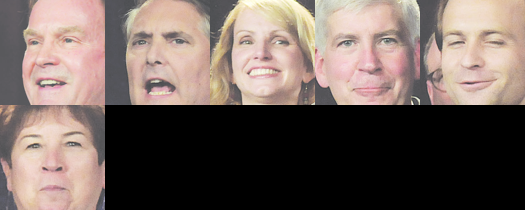

Results found in file a-3.png


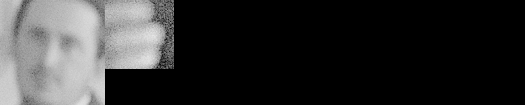

In [14]:
# Specify name of zip file in which the images are in.
small_image_file = "readonly/small_img.zip"
# Create the list of dictionaries with the keys: file_name, pil_image, bounding_boxes, text
small_images_info_list = image_info_list(small_image_file, scaleFactor=1.3, minNeighbors = 5, minSize=(53, 53))
# Iterate over list and pass in each dictionary:
for d in small_images_info_list:
    keyword_contact_sheet(d, "Christopher", 105, 105)

### Final code for large image file

The following file is complete: a-0.png
The following file is complete: a-1.png
The following file is complete: a-10.png
The following file is complete: a-11.png
The following file is complete: a-12.png
The following file is complete: a-13.png
The following file is complete: a-2.png
The following file is complete: a-3.png
The following file is complete: a-4.png
The following file is complete: a-5.png
The following file is complete: a-6.png
The following file is complete: a-7.png
The following file is complete: a-8.png
The following file is complete: a-9.png
Results found in file a-0.png


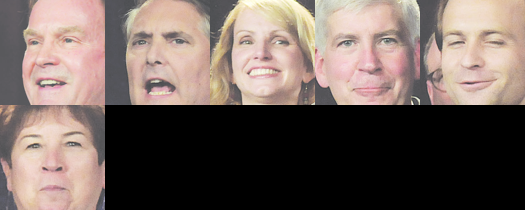

Results found in file a-1.png


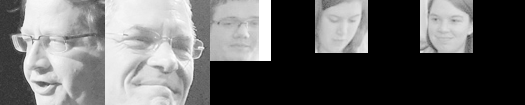

Results found in file a-10.png
But there were no faces in that file!
Results found in file a-13.png


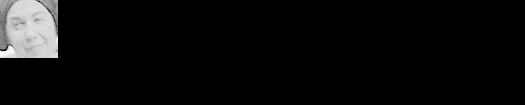

Results found in file a-2.png


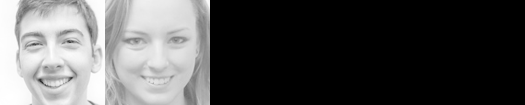

Results found in file a-3.png


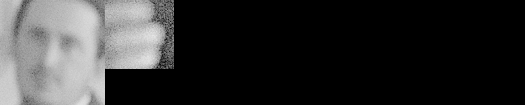

Results found in file a-8.png
But there were no faces in that file!


In [15]:
# Specify name of zip file in which the images are in.
all_images = 'readonly/images.zip'
# Create the list of dictionaries with the keys: file_name, pil_image, bounding_boxes, text
all_images_info_list = image_info_list(all_images, scaleFactor=1.3, minNeighbors = 5, minSize=(53, 53))
# Iterate over list and pass in each dictionary:
for d in all_images_info_list:
    keyword_contact_sheet(d, "Mark", 105, 105)